In [5]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

In [7]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace
import bbmm.operators.dense_linear_operator as dense_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
import bbmm.operators.diag_linear_operator as diag_linear_operator
import bbmm.operators._linear_operator as _linear_operator
import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(dense_linear_operator)
    importlib.reload(root_linear_operator)
    importlib.reload(diag_linear_operator)
    importlib.reload(_linear_operator)
    importlib.reload(psd_sum_linear_operator)
    importlib.reload(root_linear_operator)
reload()

In [8]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [9]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
import stopro.GP.gp_1D_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam

# larger scale

In [10]:
project_name = 'data'
simulation_name = 'test_loss_sin1d_naive_y_1000_x100'
hdf_operator = HdfOperator(f'{project_name}/{simulation_name}')

In [11]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [12]:
scale=100

In [13]:
simulation_name = 'test_loss_sin1d_naive_y_1000_x100'

In [14]:
data_preparer = DataPreparer(
    project_name, simulation_name, class_data_generator=Sin1DNaive)
data_preparer.load_params(
    system_name="sin_1D_naive", use_existing_params=False
)

In [15]:
r_train, f_train = hdf_operator.load_train_data(data_preparer.lbls["train"], data_preparer.vnames["train"])
r_test, f_test = hdf_operator.load_test_data(data_preparer.lbls["test"], data_preparer.vnames["test"])

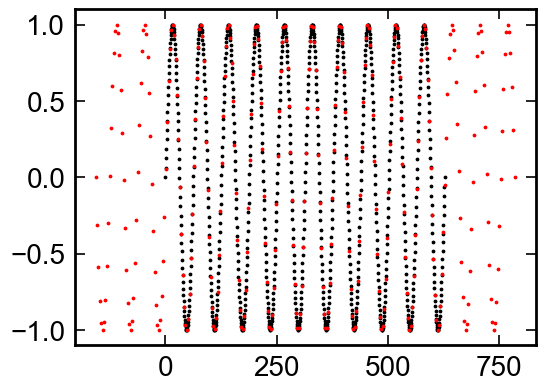

In [16]:
plt.scatter(r_train[0], f_train[0], s=3)
plt.scatter(r_test[0], f_test[0], s=3)

In [17]:
init

Array([0., 0.], dtype=float64)

In [18]:
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])
params_model["epsilon"] = 1e-06
args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]
noise = params_model["epsilon"]

In [19]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_naive.GPmodel1DNaive(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [20]:
K = gp_model.trainingK_all(init, r_train)
# K_torch = torch.from_numpy(np.array(K))
K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
is_positive_definite(K), jnp.linalg.cond(K)

(True, Array(126659.1630853, dtype=float64))

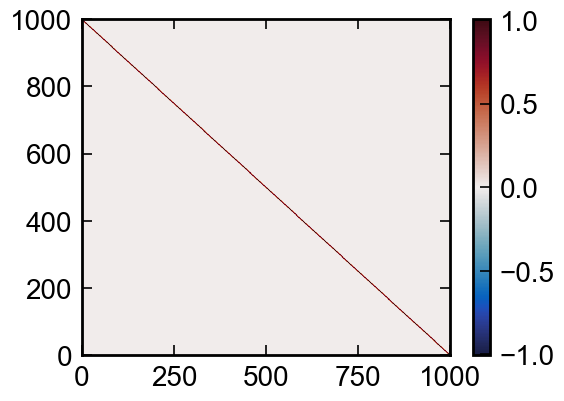

In [43]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [21]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_naive.GPmodel1DNaive(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [23]:
def setup_loss_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.01, max_tridiag_iter=20, max_iter_cg=1000):
    def loss_mpcg(init, *args):

        r, delta_y, noise = args

        K = gp_model.trainingK_all(init, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=seed)
        else:
            zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
        # zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
        # zs = zs/zs_norms
        rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j,t_mat = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=n_tridiag, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )

        logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)

        yKy = jnp.dot(delta_y, Kinvy[:, -1])
        loss = (yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2)    
        # print(yKy)
        # print(logdet)
        return loss
    return loss_mpcg

In [37]:
loglikelihood_mpcg = setup_loss_mpcg(seed=1, rank=15, n_tridiag=10, max_tridiag_iter=20, max_iter_cg=3000, tolerance=1)

In [38]:
func_mpcg = logposterior(loglikelihood_mpcg, params_optimization)
dfunc_mpcg = jit(grad(func_mpcg, 0))
hess_mpcg= hessian(func_mpcg)

In [26]:
func_mpcg(init, *args_predict[2:])

Array(-192.76396994, dtype=float64)

In [27]:
func(init, *args_predict[2:])

Array(-392.89297031, dtype=float64)

In [28]:
grad(func_mpcg, 0)(init, *args_predict[2:])

Array([  437.93435383, -2021.69122791], dtype=float64)

In [29]:
params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 5
params_optimization["eps"] = 0.01
params_optimization["lr"] = 0.1
params_optimization["print_process"] = False

In [30]:
params_optimization

{'eps': 0.01,
 'index_fixed': None,
 'interval_check': None,
 'loss_ridge_regression': False,
 'lr': 0.1,
 'maxiter_GD': 5,
 'maxiter_scipy': [0],
 'method_GD': 'adam',
 'method_scipy': ['Nelder-Mead'],
 'print_process': False}

In [31]:
params_optimization["maxiter_GD"] = 50
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: -0.39289297030777925
converged


In [36]:
jnp.exp(opt), len(loss)

(Array([ 0.1304871 , 15.12627027], dtype=float64), 41)

In [39]:
params_optimization["print_process"] = True

In [40]:
opts_mpcg = [{"x": init}]
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: -0.19276396993534559
step   0 loss: -0.1928 max_grad: 2.02169, arg=1
norm_of_grads: 2.06858
[-0.1  0.1]
step   1 loss: -0.4352 max_grad: 1.88533, arg=1
norm_of_grads: 1.93550
[-0.2     0.1998]
step   2 loss: -0.6595 max_grad: 1.76396, arg=1
norm_of_grads: 1.81745
[-0.3     0.2991]
step   3 loss: -0.8734 max_grad: 1.61425, arg=1
norm_of_grads: 1.67252
[-0.4     0.3978]
step   4 loss: -1.0728 max_grad: 1.36087, arg=1
norm_of_grads: 1.42928
[-0.5     0.4951]
step   5 loss: -1.2647 max_grad: 1.53474, arg=1
norm_of_grads: 1.59561
[-0.6     0.5922]
step   6 loss: -1.4451 max_grad: 1.41548, arg=1
norm_of_grads: 1.48117
[-0.6999  0.6887]
step   7 loss: -1.6184 max_grad: 54.38732, arg=1
norm_of_grads: 54.38845
[-0.7987  0.745 ]
step   8 loss: -1.7311 max_grad: 17.42650, arg=1
norm_of_grads: 17.43347
[-0.8983  0.8075]
step   9 loss: -1.8446 max_grad: 99.67481, arg=1
norm_of_grads: 99.67565
[-0.9976  0.7933]
step  10 loss: -1.8720 max_grad: 115.80477, arg=1
norm_of_grads: 11

In [41]:
jnp.exp(opt_mpcg)

Array([0.39014164, 2.38766925], dtype=float64)

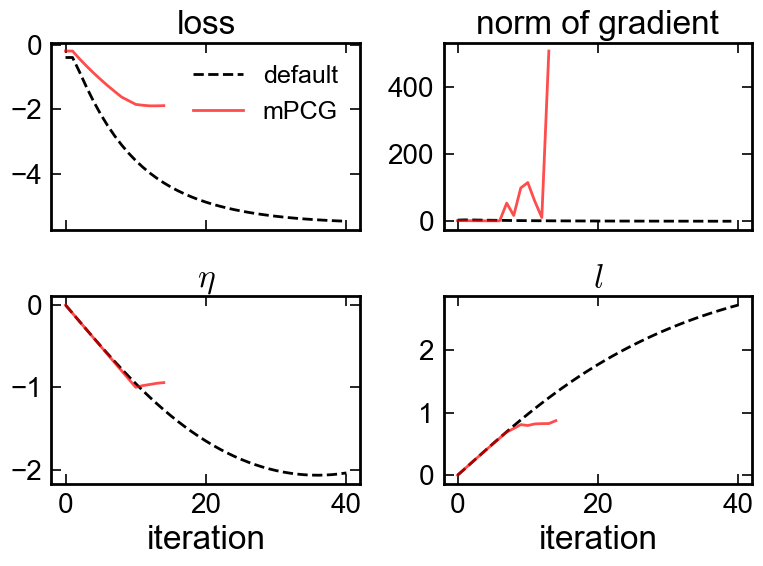

In [44]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='default')
axs[0][0].plot(loss_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [42]:
fs, Σs = predictor(opt, *args_predict)

In [43]:
std = np.sqrt(np.diag(Σs[0]))

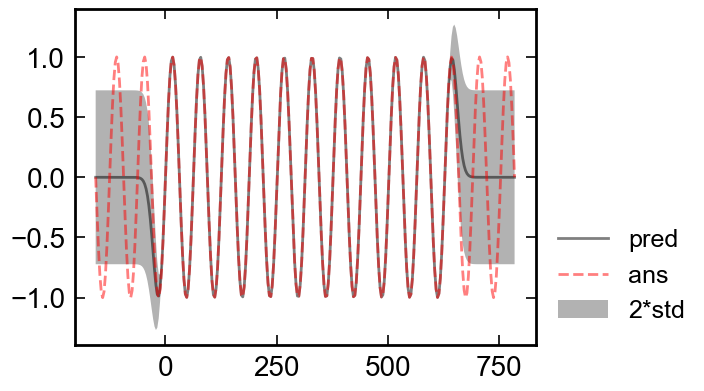

In [46]:
fig, ax = plt.subplots()
ax.plot(r_test[0], fs[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
# ax.scatter(r_train[0], f_train[0], label='training')
ax.fill_between(r_test[0], fs[0]-std*2, fs[0]+std*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))

In [47]:
def setup_predictor_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.01, max_tridiag_iter=20, max_iter_cg=1000):
    def predictor_mpcg(opt, *args):

        r_test, μ_test, r, delta_y, noise = args

        K = gp_model.trainingK_all(opt, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
        
        Kab = gp_model.mixedK_all(opt, r_test, r_train)
        Kaa = gp_model.testK_all(opt, r_test)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        rhs = jnp.concatenate([delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )
        
        rhs = Kab.T

        Kinvk, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )


        kKy = jnp.matmul(Kab, Kinvy)
        kKk = jnp.matmul(Kab, Kinvk)
        print(kKy.shape)
        f_infer_mpcg = [μ_test[0] + jnp.squeeze(kKy, axis=1)]
        Sigma_mpcg = Kaa - kKk
        # print(yKy)
        # print(logdet)
        return f_infer_mpcg, Sigma_mpcg
    return predictor_mpcg

In [64]:
predictor_mpcg = setup_predictor_mpcg(tolerance=0.0001, max_iter_cg=3000)

In [65]:
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)

(300, 1)


/home/ogawa_kenta/research/M2/bbmm_implementation/duplication_of_bbmm/bbmm/utils/conjugate_gradient.py:236: UserWarning: Did not converge after 3000 iterations. Final residual norm was 0.000343595760502145. consider raising max_cg_iter or rank of the preconditioner.
  warnings.warn(


In [66]:
std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg))

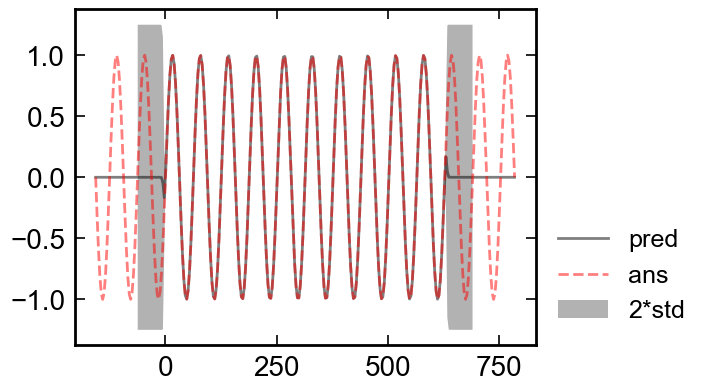

In [67]:
fig, ax = plt.subplots()
ax.plot(r_test[0], f_infer_mpcg[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.fill_between(r_test[0], f_infer_mpcg[0]-std_mpcg*2, f_infer_mpcg[0]+std_mpcg*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))
plt.show()

In [1]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}

axs[0][0].plot(loss, **kwargs, label='default')
axs[0][0].plot(loss_mpcg, label='mPCG')
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG')
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0])
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1])
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

NameError: name 'plt' is not defined